# **Authors**

***The work can be done in groups of up to 3 students. Please complete the following fields with your group number and list your names and HDU ID numbers.***

> **[HDU-AT_-25] Computer Vision**
>
> 1. Абрамов Максим, 311786
> 2. Васильев Фёдор, 312227
> 3. Чакчир Дмитрий, 291704

The task and guidelines were prepared by Andrei Zhdanov and Sergei Shavetov, ITMO University, 2025.

# **Practical Assignment No 2. Hough Transform**

***Study of the Hough transform to find geometric primitives.***

To implement the current practical assignment task we would need OpenCV, scikit-image and NumPy libraries along with image display functions we wrote during the Image Processing class. We import OpenCV's `cv2` library as `cv` for easier use.

In [1]:
# Import OpenCV library as both cv2 and cv
import cv2
import cv2 as cv
# Import NumPy library as np
import numpy as np
# Import math for, yes we just need math 
import math
# Import scikit-image transform library for Hough transformation
import skimage.transform
# Import functions from our utility library
from pa_utils import ShowImages, exit

# **Introduction**

In the current practical assignment, we will learn some basic object detection methods that allow searching for objects on an image using the common locus method.

## Common Locus of Points

The main principle of the Hough transform [1] is to find a common *locus of points*. For example, this approach is used when designing a triangle along three given sides. At first one side of the triangle is laid off, after that the ends of the segment are considered as the centers of circles with radii equal to the lengths of the second and third segments. The intersection of the two circles is the common locus of points, from where the segments are drawn to the ends of the first segment. In other words, a *voting* of two points was held in favor of the probable location of the third vertex of the triangle. As a result of *voting* the *winner* was the point that got two *votes* (the points on the circles got one vote each, and outside them, they got zero), see Fig. 1.

[1]: Hough, P. V. C. (1962, December 18). Method and means for recognizing complex patterns (U.S. Patent No. 3,069,654). Google Patents.

| ![Finding a triangle by given three sides](images/pa2_fig1.png "Finding a triangle by given three sides") | 
|:--:| 
| ***Fig. 1.*** *Finding a triangle by the given three sides.* |

Let's generalize this idea for working with real data when the image has a large number of special feature points participating in the vote. Let us assume that it is necessary to search a circle of known radius $R$ in a binary point set, and in this set, there may also be false points that do not lie on the desired circle. The set of possible circle centers for the desired radius around each characteristic point forms a circle of radius $R$, see Fig. 2 below. Thus, the point corresponding to the maximum intersection of the number of circles will be the center of the required radius circle.

| ![Searching a circle of known radius in a point set](images/pa2_fig2.png "Searching a circle of known radius in a point set") | 
|:--:| 
| ***Fig. 2.*** *Searching a circle of known radius in a point set.* |

## Classic Hough Transform

The classic Hough transform is based on the considered point voting idea. It was originally designed to select lines on binary images. The Hough transform uses the parameter space to search for geometric primitives. The most well-known parametric equation of lines is:

$$
	y=kx+b,
$$

This equation has a problem as it can not be used to define lines that are parallel to the $Ox$ axis, so the Hough transform uses another common parametric equation of a line by a point and an inclination angle:

$$
	x\cos{\Theta}+y\sin{\Theta}=\rho,
$$

where 
- $\rho$ is the radius vector drawn from the origin to the line; 
- $\Theta$ is the inclination angle of the radius vector. 

Let the straight line in the Cartesian coordinate system be given by the given equation, from which it is easy to calculate the radius vector $\rho$ and angle $\Theta$. Then we can define the Hough parameter space with coordinated $\rho$ and $\Theta$. As a result, each line of the source Cartesian space will be represented by a single point with coordinates $(\rho_0,\Theta_0)$ in the Hough parameter space, see Fig. 3.

| ![Representation of a straight line in Hough space](images/pa2_fig3.png "Representation of a straight line in Hough space") | 
|:--:| 
| ***Fig. 3.*** *Representation of a straight line in Hough space.* |

During the Hough transform all lines that pass via points in the source Cartesian space are converted to points in the Hough parameter space and *vote* for corresponding lines. As a result, the parameter space sums upvotes given for various lines. In general, the parameter space is continuous, however, in a digital form, it is stored as a matrix. Therefore, in the Hough transform the Hough space is called *accumulator* and is a matrix $A(\rho,\Theta)$ that stores voting information.

An infinite number of straight lines can be drawn passing through any of the points in the source Cartesian coordinate space and they will generate a sinusoidal response function in the parameter space. Thus, any two sinusoidal response functions in the parameter space will intersect at the point $(\rho,\Theta)$ only if the points originating them in the source Cartesian space lie on a single straight line, see Fig. 4. Based on this, we can conclude that to find straight lines in the source space, it is necessary to find all the local maxima of the accumulator matrix.

| ![Voting in the Hough parameter space](images/pa2_fig4.png "Voting in the Hough parameter space") | 
|:--:| 
| ***Fig. 4.*** *Voting in the Hough parameter space.* |

The considered line search algorithm can be used in the same way to search for any other curve described in space by some function with a certain number of parameters $F=\left(a_1,a_2,...,a_n,x,y\right)$, which will only affect the dimension of the parameter space.

Let us use the Hough transform to search for circles of a given radius $R$. It is known that a circle on a plane is described by the formula:

$$
(x-x_0)^2+(y-y_0)^2=R^2
$$

The set of centers of all possible circles of radius $R$ passing through a feature point forms a circle of radius $R$ around that point. Due to this the response function in the Hough transform for finding circles is a circle of the same size centered at the voting point, see Fig. 2. Then, similarly to the previous case, it is necessary to find the local maxima of the accumulator function $A(x,y)$ in the space of parameters $(x,y)$, which will be the centers of the required circles.

The Hough transform is invariant to shift, scaling, and rotation. Taking into account that under projective transformations of three-dimensional space, straight lines always go only to straight lines (in the degenerate case, to points), the Hough transform makes it possible to detect lines invariably not only to affine transformations of the plane but also to the group of projective transformations in space.


# **Task 1. Search for Lines**

***Take three arbitrary images containing lines. Search for straight lines using various implementations of the Hough transform. Plot the found lines on the original image. Mark the start and end points of the lines. Determine the lengths of the shortest and longest lines, and calculate the number of lines found.***

## **1.1 Hough Transform for Lines with OpenCV**

OpenCV library provides two implementations for the Hough transform algorithm for search of the straight lines:

- `cv2.HoughLines(image, rho, theta, threshold) -> lines` function performs the classic Hough line transform of an `image` and searches for straight lines. The `rho` and `theta` parameters define the subdivision of Hough parameter space for the corresponding axis. The `threshold` parameter defines the threshold, i.e., the number of votes that a line should get to be added to the returned `lines` array. Each line in returned `lines` array is an infinite line which is defined by `rho` ($\rho$) and `theta` ($\Theta$) parameters.
- `cv2.HoughLinesP(image, rho, theta, threshold, minLineLength, maxLineGap) -> lines` function performs the probabilistic Hough line transform of an `image` and searches for straight lines. The main function parameters are the same, however, two extra are added: these are `minLineLength` for a minimum line length, so no line shorter than this won't be selected, and `maxLineGap` for a maximum gap between two segments of the line to consider them to be the same line instead of two separate ones. The returned 2-dimensional `lines` array contains the start and end points of each of the found line segments as arrays of four: $[x_1, y_1, x_2, y_2]$.



### **1.1.1 Classic Hough Transform for Lines with OpenCV**

To execute the Hough line transform in OpenCV first have to preprocess an image to get edges by executing the Canny algorithm.

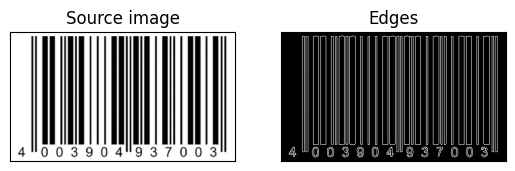

In [2]:
# Read an image from a file in BGR
fn = "images/barcode.png"
I1 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I1, np.ndarray) or I1.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Preprocess with Canny algorithm
I1edge = cv.Canny(I1, 50, 200, None, 3)
# Display it
ShowImages([("Source image", I1), 
            ("Edges", I1edge)], 2)

Then run the Hough line transform to get line parameters.

In [3]:
# Find lines with Hough transform
# Distance resolution: 1 pix
# Angle resolution: 1 deg in rad
# Accumulator threshold: 100
I1classic = cv.HoughLines(I1edge, 1, np.pi / 180, 100)

Finally, we can draw infinite lines by returned parameters with the help of the `cv2.line()` function.

Found 62 lines


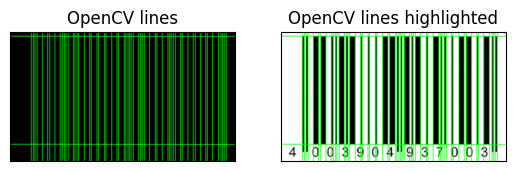

In [4]:
# Create output images
I1classic_out = I1.copy()
I1classic_lines = np.zeros_like(I1)
h, w = I1.shape[:2]
l = math.sqrt(h ** 2 + w ** 2)

# Go through all found lines and display them
if I1classic is not None:
  for i in range(0, len(I1classic)):
    rho = I1classic[i][0][0]
    theta = I1classic[i][0][1]
    a, b = math.cos(theta), math.sin(theta)
    x0, y0 = a * rho, b * rho
    pt1 = np.int32((x0 - l * b, y0 + l * a))
    pt2 = np.int32((x0 + l * b, y0 - l * a))
    cv.line(I1classic_out, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)
    cv.line(I1classic_lines, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)

# Display it
print("Found {} lines".format(len(I1classic)))
ShowImages([("OpenCV lines", I1classic_lines), 
            ("OpenCV lines highlighted", I1classic_out)], 2)

### **1.1.2 Self-work**

> ***Self-work***
>
> Take **three** arbitrary images and execute the classic Hough transform with OpenCV. Display the found lines and print their number.
>
> ***Notes.***
> 1. *You may have to change the Hough transform parameters to match your images.*

image 1 lines: 67
image 2 lines: 20
image 3 lines: 27


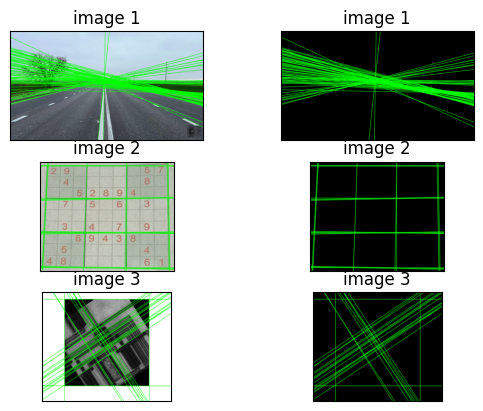

In [53]:
# TODO Place your solution here
def hough_transform(path, dist_res=1, angle_res=np.pi / 180, threshold=100):
    I1 = cv.imread(path, cv.IMREAD_COLOR)
    I1edge = cv.Canny(I1, 50, 200, None, 3)
    I1classic = cv.HoughLines(I1edge, dist_res, angle_res, threshold)

    I1classic_out = I1.copy()
    I1classic_lines = np.zeros_like(I1)
    h, w = I1.shape[:2]
    l = math.sqrt(h ** 2 + w ** 2)
  
  # Go through all found lines and display them
    if I1classic is not None:
        for i in range(0, len(I1classic)):
            rho = I1classic[i][0][0]
            theta = I1classic[i][0][1]
            a, b = math.cos(theta), math.sin(theta)
            x0, y0 = a * rho, b * rho
            pt1 = np.int32((x0 - l * b, y0 + l * a))
            pt2 = np.int32((x0 + l * b, y0 - l * a))
            cv.line(I1classic_out, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)
            cv.line(I1classic_lines, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)
            
    return len(I1classic), I1classic_out, I1classic_lines
            
images = ["images/task_1/1.png",
          "images/task_1/2.png",
          "images/task_1/3.png",]     
params = [{"dist_res": 1, "angle_res": np.pi / 180, "threshold": 130},
          {"threshold": 135},
          {"threshold": 110}]
output = []        
for i, image in enumerate(images, start=1):
    n, I1classic_out, I1classic_lines = hough_transform(image, **params[i-1])
    print(f"image {i} lines: {n}")
    output.append((f"image {i}", I1classic_out))
    output.append((f"image {i}", I1classic_lines))

ShowImages(output, 2)

### **1.1.3 Probabilistic Hough Transform for Lines with OpenCV**

The probabilistic Hough line transform is executed similarly:

In [48]:
# Find lines with Probabilistic Hough transform
# Distance resolution: 1 pix
# Angle resolution: 1 deg in rad
# Accumulator threshold: 50
# Minimum line length: 50
# Maximum line gap: 4
I1prob = cv.HoughLinesP(I1edge, 1, np.pi / 180, 50, None, 50, 4)

The probabilistic Hough transform will return an array of pairs of the endpoints of the found line segments which we can use to draw them on top of the source image:

Found 60 lines
The shortest found line length is 204.0
The shortest found line is (385, 212) - (385, 8)
The longest found line length is 220.0
The longest found line is (227, 228) - (227, 8)


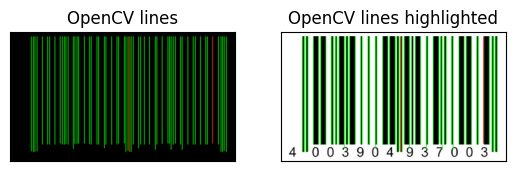

In [49]:
# Create and output image
I1prob_out = I1.copy()
I1prob_lines = np.zeros_like(I1)

# Go through all found lines and display them
if I1prob is not None:
  min_line = max_line = I1prob[0][0]
  min_line_len = max_line_len = math.sqrt((min_line[0] - min_line[2]) ** 2 + (min_line[1] - min_line[3]) ** 2)
  for i in range(1, len(I1prob)):
    l = I1prob[i][0]
    line_len = math.sqrt((l[0] - l[2]) ** 2 + (l[1] - l[3]) ** 2)
    if line_len < min_line_len:
      min_line_len = line_len
      min_line = l
    if line_len > max_line_len:
      max_line_len = line_len
      max_line = l
    cv.line(I1prob_out, (l[0], l[1]), (l[2], l[3]), (0, 255, 0), 1, cv.LINE_AA)
    cv.line(I1prob_lines, (l[0], l[1]), (l[2], l[3]), (0, 255, 0), 1, cv.LINE_AA)
    
  # Draw min and max lines
  cv.line(I1prob_out, (min_line[0], min_line[1]), (min_line[2], min_line[3]), (0, 0, 255), 1, cv.LINE_AA)
  cv.line(I1prob_lines, (min_line[0], min_line[1]), (min_line[2], min_line[3]), (0, 0, 255), 1, cv.LINE_AA)
  cv.line(I1prob_out, (max_line[0], max_line[1]), (max_line[2], max_line[3]), (0, 0, 255), 1, cv.LINE_AA)
  cv.line(I1prob_lines, (max_line[0], max_line[1]), (max_line[2], max_line[3]), (0, 0, 255), 1, cv.LINE_AA)
  
  # Display it
  print("Found {} lines".format(len(I1prob)))
  print("The shortest found line length is {}".format(min_line_len))
  print("The shortest found line is ({}, {}) - ({}, {})".format(min_line[0], min_line[1], min_line[2], min_line[3]))
  print("The longest found line length is {}".format(max_line_len))
  print("The longest found line is ({}, {}) - ({}, {})".format(max_line[0], max_line[1], max_line[2], max_line[3]))
ShowImages([("OpenCV lines", I1prob_lines), 
            ("OpenCV lines highlighted", I1prob_out)], 2)

### **1.1.4 Self-work**

> ***Self-work***
>
> Take **three** arbitrary images and execute the probabilistic Hough transform with OpenCV. Display the found lines, print their number, and print the shortest and the longest line parameters.
>
> ***Notes.***
> 1. *You may have to change the Hough transform parameters to match your images.*

image 1
Found 10 lines
The shortest found line length is 129.75746606650424
The shortest found line is (0, 241) - (126, 210)
The longest found line length is 251.26878039263056
The longest found line is (2, 239) - (246, 179)


image 2
Found 2144 lines
The shortest found line length is 2.0
The shortest found line is (99, 100) - (101, 100)
The longest found line length is 56.0
The longest found line is (223, 1) - (279, 1)


image 3
Found 21 lines
The shortest found line length is 60.74537019394976
The shortest found line is (184, 206) - (235, 173)
The longest found line length is 118.15244390193544
The longest found line is (180, 158) - (278, 92)




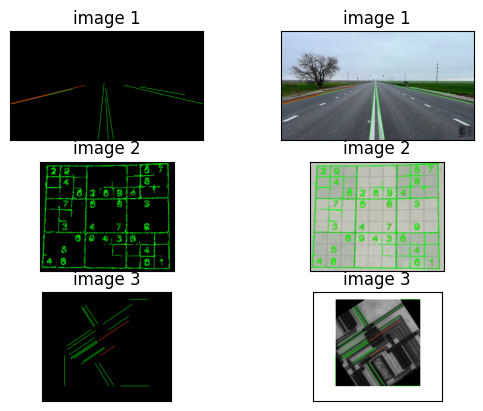

In [102]:
# TODO Place your solution here
def probabilistic_hough_transform(path, dist_res=1, angle_res=np.pi / 180, threshold=100, min_len=50, max_gap=4):
    I1 = cv.imread(path, cv.IMREAD_COLOR)
    I1edge = cv.Canny(I1, 50, 200, None, 3)
    I1prob = cv.HoughLinesP(I1edge, dist_res, angle_res, threshold, None, min_len, max_gap)
    I1prob_out = I1.copy()
    I1prob_lines = np.zeros_like(I1)
    
    # Go through all found lines and display them
    if I1prob is not None:
        min_line = max_line = I1prob[0][0]
        min_line_len = max_line_len = math.sqrt((min_line[0] - min_line[2]) ** 2 + (min_line[1] - min_line[3]) ** 2)
        for i in range(1, len(I1prob)):
            l = I1prob[i][0]
            line_len = math.sqrt((l[0] - l[2]) ** 2 + (l[1] - l[3]) ** 2)
            if line_len < min_line_len:
                min_line_len = line_len
                min_line = l
            if line_len > max_line_len:
                max_line_len = line_len
                max_line = l
            cv.line(I1prob_out, (l[0], l[1]), (l[2], l[3]), (0, 255, 0), 1, cv.LINE_AA)
            cv.line(I1prob_lines, (l[0], l[1]), (l[2], l[3]), (0, 255, 0), 1, cv.LINE_AA)
    
        # Draw min and max lines
        cv.line(I1prob_out, (min_line[0], min_line[1]), (min_line[2], min_line[3]), (0, 0, 255), 1, cv.LINE_AA)
        cv.line(I1prob_lines, (min_line[0], min_line[1]), (min_line[2], min_line[3]), (0, 0, 255), 1, cv.LINE_AA)
        cv.line(I1prob_out, (max_line[0], max_line[1]), (max_line[2], max_line[3]), (0, 0, 255), 1, cv.LINE_AA)
        cv.line(I1prob_lines, (max_line[0], max_line[1]), (max_line[2], max_line[3]), (0, 0, 255), 1, cv.LINE_AA)
    
        # Display it
        print("Found {} lines".format(len(I1prob)))
        print("The shortest found line length is {}".format(min_line_len))
        print("The shortest found line is ({}, {}) - ({}, {})".format(min_line[0], min_line[1], min_line[2], min_line[3]))
        print("The longest found line length is {}".format(max_line_len))
        print("The longest found line is ({}, {}) - ({}, {})".format(max_line[0], max_line[1], max_line[2], max_line[3]))
        
        return I1prob_lines, I1prob_out
    
    
    
images = ["images/task_1/1.png",
          "images/task_1/2.png",
          "images/task_1/3.png",]     
params = [{"threshold": 100, "min_len": 120, "max_gap": 3},
          {"threshold": 2, "min_len": 2, "max_gap": 3},
          {"threshold": 100, "min_len": 50, "max_gap": 1}]
output = []        
for i, image in enumerate(images, start=1):
    print(f"image {i}")
    I1classic_out, I1classic_lines = probabilistic_hough_transform(image, **params[i-1])
    print("\n")
    output.append((f"image {i}", I1classic_out))
    output.append((f"image {i}", I1classic_lines))

ShowImages(output, 2)
    

## **1.2 Hough Transform for Lines with scikit-image**

Unfortunately, OpenCV does not provide the functionality to obtain the Hough accumulator matrix. However, the scikit-image library also provides functions that we can use to perform the Hough transform, and opposite to OpenCV, scikit-image executes it in several steps thus allowing us to process and display the Hough parameter space.

Same as OpenCV, scikit-image provides two implementations for the Hough transform algorithm for search of the straight lines. These are classic and probabilistic approaches. The main difference between OpenCV and scikit-image libraries is that in the classic approach the Hough transform contains two steps:
1. Calculation of the Hough parameter space;
2. Search for peaks in the Hough parameter space to find lines.

The following functions for Hough transform for lines are provided in scikit-image:

- `skimage.transform.hough_line(image, thetas) -> hspace, angles, distances` function performs the classic Hough line transform of an `image` and calculates the Hough accumulator matrix (parameter space). The `thetas` parameter defines an array of $\Theta$ angles in radians to subdivide the Hough parameter space (defaults to 180 values in the range $[-\pi/2, \pi/2]$). It returns a tuple with three items, which are `hspace` with the Hough transform accumulator matrix; `angles` with the array of $\Theta$ angles in radians which define the Hough parameter space; and `distances` with the array of $\rho$ distances which define the Hough parameter space.

- `skimage.transform.hough_line_peaks(hspace, angles, distances, min_distance, min_angle, threshold num_peaks) -> accum, theta, rho` function performs the search for peak values in the Hough parameter space acquired at the previous step. The input parameters list contains the data acquired from `skimage.transform.hough_line()` function with additional parameters for minimum distance and angle between two lies to consider them separate lines (`min_distance` and `min_angle` parameters, defined in the accumulator matrix dimensions), the minimum peak value `threshold` to choose (defaults to the half of the maximum `hspace` value) and the maximum number of peaks to search for (`num_peaks` parameter). It returns a tuple of three items (`accum`, `theta`, `rho`) corresponding to peak values in the Hough accumulator matrix. Each line in the returned arrays is an infinite line which is defined by a pair of `rho` ($\rho$) and `theta` ($\Theta$) parameters with the same array indices that scored the corresponding `accum` *votes*.

- `skimage.transform.probabilistic_hough_line(image, threshold, line_length, line_gap, theta) -> lines` function performs the probabilistic Hough line transform of an `image` and searches for straight lines. The main function parameters are similar to the ones used in OpenCV. They are the `threshold` for the minimum required peak value, the minimum line length to consider (`line_length` parameter), the maximum gap between two segments of the same line (`line_gap` parameter), and an array `theta` of $\Theta$ angles to use during transformation.  The returned 3-dimensional `lines` array contains the start and end points of each of the found line segments as 2D arrays with four elements: $[[x_1, y_1], [x_2, y_2]]$.



### **1.2.1 Classic Hough Transform for Lines with scikit-image**

Same with the OpenCV library, to execute the Hough line transform in scikit-image first we have to preprocess an image to get edges by executing the Canny algorithm.

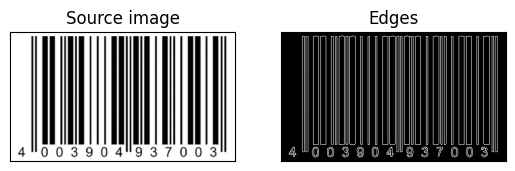

In [103]:
# Read an image from file in BGR
fn = "images/barcode.png"
I1 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I1, np.ndarray) or I1.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Preprocess with Canny algorithm
I1edge = cv.Canny(I1, 50, 200, None, 3)
# Display it
ShowImages([("Source image", I1), 
            ("Edges", I1edge)], 2)

Then run the Hough line transform to get the Hough parameter space accumulator matrix. Since now we have the accumulator matrix we can display it as well to see how the parameter space is formed.

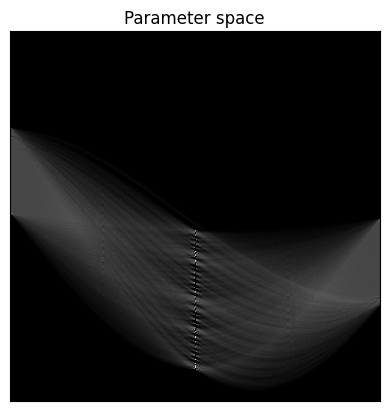

In [104]:
# Do Hough transform
# We will use 360 angles instead of the default 180
thetas = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint = False)
I1h, angles, distances = skimage.transform.hough_line(I1edge, theta = thetas)
# Show Hough parameter space
# We will resize it to make square for a better display
ShowImages([("Parameter space", cv.resize(I1h.astype(np.float32) / np.max(I1h), (I1h.shape[1], I1h.shape[1])))])

Now we can search for the maxima values in the Hough parameter space.

In [105]:
# Find lines with Hough transform
# Minimum distance between lines: 0
# Minimum angle between lines: 0
I1accum, I1theta, I1rho = skimage.transform.hough_line_peaks(I1h, angles, distances, min_distance = 0, min_angle = 0)

Finally, we can draw the infinite lines found by the scikit-image Hough transform implementation with subsequent calls to the `cv2.line()` function.

Found 62 lines


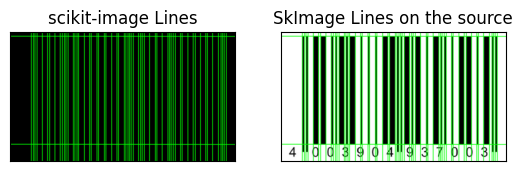

In [106]:
# Create output images
I1classic_out = I1.copy()
I1classic_lines = np.zeros_like(I1)
h, w = I1.shape[:2]
l = math.sqrt(h ** 2 + w ** 2)

# Go through all found lines and display them
if I1theta is not None and I1rho is not None:
  for i in range(0, len(I1theta)):
    a, b = math.cos(I1theta[i]), math.sin(I1theta[i])
    x0, y0 = a * I1rho[i], b * I1rho[i]
    pt1 = np.int32((x0 - l * b, y0 + l * a))
    pt2 = np.int32((x0 + l * b, y0 - l * a))
    cv.line(I1classic_out, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)
    cv.line(I1classic_lines, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)

# Display it
print("Found {} lines".format(len(I1theta)))
ShowImages([("scikit-image Lines", I1classic_lines), 
            ("SkImage Lines on the source", I1classic_out)], 2)

### **1.2.2 Self-work**

> ***Self-work***
>
> Take **three** arbitrary images and execute the classic Hough transform with the scikit-image library. Display the Hough parameter space and found lines. Print the found lines their number.
>
> ***Notes.***
> 1. *You may have to change the Hough transform parameters to match your images.*

image 1 lines count: 8
image 2 lines count: 18
image 3 lines count: 20


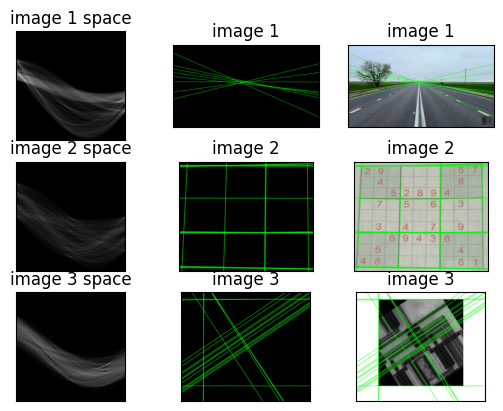

In [112]:
# TODO Place your solution here
def hough_transform_sklearn(path, min_distance=0, min_angle=0):
    I1 = cv.imread(path, cv.IMREAD_COLOR)
    I1edge = cv.Canny(I1, 50, 200, None, 3)
    
    thetas = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint = False)
    I1h, angles, distances = skimage.transform.hough_line(I1edge, theta = thetas)
    parameter_space  = cv.resize(I1h.astype(np.float32) / np.max(I1h), (I1h.shape[1], I1h.shape[1]))
    
    I1accum, I1theta, I1rho = skimage.transform.hough_line_peaks(I1h, angles, distances, min_distance=min_distance, min_angle=min_angle)
    
    
    I1classic_out = I1.copy()
    I1classic_lines = np.zeros_like(I1)
    h, w = I1.shape[:2]
    l = math.sqrt(h ** 2 + w ** 2)
    
    # Go through all found lines and display them
    if I1theta is not None and I1rho is not None:
      for i in range(0, len(I1theta)):
        a, b = math.cos(I1theta[i]), math.sin(I1theta[i])
        x0, y0 = a * I1rho[i], b * I1rho[i]
        pt1 = np.int32((x0 - l * b, y0 + l * a))
        pt2 = np.int32((x0 + l * b, y0 - l * a))
        cv.line(I1classic_out, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)
        cv.line(I1classic_lines, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)
        
    return len(I1theta), parameter_space, I1classic_lines, I1classic_out


images = ["images/task_1/1.png",
          "images/task_1/2.png",
          "images/task_1/3.png",]     
params = [{"min_distance": 10, "min_angle": 90},
          {},
          {}]
output = []      
for i, image in enumerate(images, start=1):
    n, parameter_space, I1classic_out, I1classic_lines = hough_transform_sklearn(image, **params[i-1])
    print(f"image {i} lines count:", n)
    output.append((f"image {i} space", parameter_space))
    output.append((f"image {i}", I1classic_out))
    output.append((f"image {i}", I1classic_lines))

ShowImages(output, 3)
    

### **1.2.3 Probabilistic Hough Transform for Lines with scikit-image**

The probabilistic Hough line transform with scikit-image is executed in a way similar to OpenCV. The only two differences are that now you have to use the `skimage.transform.probabilistic_hough_line(image, threshold, line_length, line_gap, theta) -> lines` function and returned lines parameters ara in 3D array instead of 2D array in OpenCV. So, the line length calculation will be as follows:
```python
line = lines[i]
line_len = math.sqrt((line[0][0] - line[1][0]) ** 2 + (line[0][1] - line[1][1]) ** 2)
```

And the line drawing will be as follows:
```python
color = (0, 0, 255) # Color in OpenCV is defined in BGR, so this will be the Red color
cv.line(Iout, lines[i][0], lines[i][1], color, 1, cv.LINE_AA)
```

### **1.2.4 Self-work**

> ***Self-work***
>
> Take **three** arbitrary images and execute the probabilistic Hough transform with the scikit-image library. Display the found lines, print their number, and print the shortest and the longest line parameters.
>
> ***Notes.***
> 1. *You may have to change the Hough transform parameters to match your images.*

image 1
Found 11 lines
The shortest found line length is 120.01666550941998
The shortest found line is (309, 299) - (311, 179)
The longest found line length is 259.2778432492835
The longest found line is (17, 235) - (269, 174)


image 2
Found 1168 lines
The shortest found line length is 2.0
The shortest found line is (233, 214) - (231, 214)
The longest found line length is 360.0
The longest found line is (360, 1) - (0, 1)


image 3
Found 42 lines
The shortest found line length is 58.0
The shortest found line is (72, 83) - (72, 25)
The longest found line length is 114.54693361238441
The longest found line is (182, 160) - (277, 96)




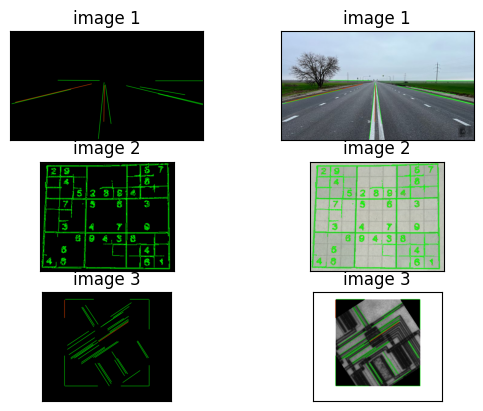

In [126]:
# TODO Place your solution here
def probabilistic_hough_transform_sklearn(path, threshold=100, line_length=50, line_gap=4):
    I1 = cv.imread(path, cv.IMREAD_COLOR)
    I1edge = cv.Canny(I1, 50, 200, None, 3)
    
    thetas = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint = False)
    lines = skimage.transform.probabilistic_hough_line(I1edge, threshold, line_length, line_gap, theta=thetas)   
    
    I1classic_out = I1.copy()
    I1classic_lines = np.zeros_like(I1)
    
    min_len, max_len = float('inf'), float('-inf')
    min_line, max_line = None, None
    
    for line in lines:
        line_len = math.sqrt((line[0][0] - line[1][0]) ** 2 + (line[0][1] - line[1][1]) ** 2)
        
        if line_len < min_len:
            min_len = line_len
            min_line = line
            
        if line_len > max_len:
            max_len = line_len
            max_line = line

        cv.line(I1classic_lines, line[0], line[1], (0, 255, 0), 1, cv.LINE_AA)
        cv.line(I1classic_out, line[0], line[1], (0, 255, 0), 1, cv.LINE_AA)
            
    cv.line(I1classic_lines, min_line[0], min_line[1], (0, 0, 255), 1, cv.LINE_AA)
    cv.line(I1classic_lines, max_line[0], max_line[1], (0, 0, 255), 1, cv.LINE_AA)
    cv.line(I1classic_out, min_line[0], min_line[1], (0, 0, 255), 1, cv.LINE_AA)
    cv.line(I1classic_out, max_line[0], max_line[1], (0, 0, 255), 1, cv.LINE_AA)
    
    print("Found {} lines".format(len(lines)))
    print("The shortest found line length is {}".format(min_len))
    print("The shortest found line is ({}, {}) - ({}, {})".format(min_line[0][0], min_line[0][1], min_line[1][0], min_line[1][1]))
    print("The longest found line length is {}".format(max_len))
    print("The longest found line is ({}, {}) - ({}, {})".format(max_line[0][0], max_line[0][1], max_line[1][0], max_line[1][1]))
        
    return I1classic_lines, I1classic_out


images = ["images/task_1/1.png",
          "images/task_1/2.png",
          "images/task_1/3.png",]     
params = [{"threshold": 100, "line_length": 120, "line_gap": 3},
          {"threshold": 2, "line_length": 2, "line_gap": 3},
          {"threshold": 100, "line_length": 50, "line_gap": 1}]
output = []        
for i, image in enumerate(images, start=1):
    print(f"image {i}")
    I1classic_out, I1classic_lines = probabilistic_hough_transform_sklearn(image, **params[i-1])
    print("\n")
    output.append((f"image {i}", I1classic_out))
    output.append((f"image {i}", I1classic_lines))

ShowImages(output, 2)

# **Task 2. Search for Circles**

***Take three arbitrary images containing circles. Search for circles of a known radius range using the Hough transform. Plot the found circles on the original image and print the number of found circles.***

When searching for circles, the Hough parameter space becomes 3-dimensional. The third dimension here is added for the circle radius. Since the circle radius can be of an infinite range, it is required to define this range when executing the Hough transform operations to create the correct accumulator space 3D matrix.

## **2.1 Hough Transform for Circles with OpenCV**

The search for circles with OpenCV is rather straightforward. You don't need to do any image preprocessing as the Canny algorithm is built into a Hough transform implementation. To run Hough transform for circles with OpenCV you have to use the following function:

- `cv.HoughCircles(image, method, dp, minDist, param1, param2, minRadius, maxRadius) -> circles` function is used to execute the Hough transform for Circles on a **grayscale** `image`. It returns a 2-dimensional array of circles where each circle has three parameters: $(x_0, y_0, R)$ - for the center of the circle and its radius. The Hough transform for circles is parameterized in the following way:
    - `method` parameter defines one of two possible methods for this transformation, it can be either `cv2.HOUGH_GRADIENT` or `cv2.HOUGH_GRADIENT_ALT`. These methods are almost similar, however the second one should give a bit better accuracy.
    - `dp` parameter defines the scale ratio of the accumulator matrix. The resolution of the accumulator matrix is `dp` times smaller than the resolution of the source image. In most cases, $1.5$ would fit well.
    - `minDist` parameter defines the minimum distance between circle centers to be detected.
    - `param1` is a high threshold that is passed to the Canny edge detector, while the low threshold would be equal to half of `param1`.
    - `param2` parameter defines the threshold for the circle detection. In the case of the `cv2.HOUGH_GRADIENT` method, it is the accumulator matrix value, while for the `cv2.HOUGH_GRADIENT_ALT` method it is the circle quality measure defined in $[0, 1]$ range where $1$ is a perfect circle.
    - `minRadius` and `maxRadius` parameters define the circle radius search range. This will define the third dimension of the Hough parameter space accumulator matrix range.

To display the found circles the `cv2.circle(image, center, radius, color, thickness, lineType)` function may be used to draw a circle on the `image` with the given `center` point, `radius`, and `thickness`. The $lineType$ parameter is used to define the type of the line, which can be set to `cv2.LINE_AA` for an antialiased line.

For example, drawing a circle on an image `Iout` with center $(50,  50)$ and radius $10$ and thickness $1$ with blue color would be written as follows:

```python
cv2.circle(Iout, (50, 50), 10, (255, 0, 0), 1)
```

### **2.1.1 Self-work**

> ***Self-work***
>
> Implement the search for circles with the Hough transform and OpenCV.
> 
> Take **three** arbitrary images and execute the Hough transform for circles with OpenCV. Display the found circles, and print their number.
>
> ***Note.*** *You may have to change the Hough transform parameters to match your images.*

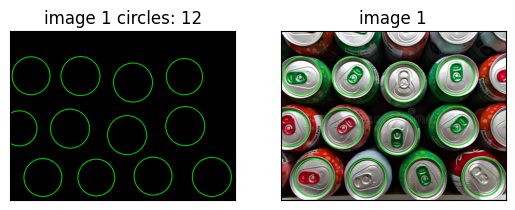

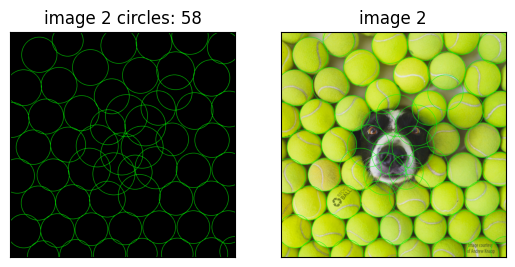

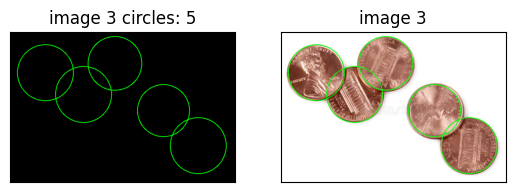

In [188]:
# TODO Place your solution here
def hough_transform_circle(path, method=cv.HOUGH_GRADIENT, dp=1.5, minDist=50, param1=70, param2=60, minRadius=0, maxRadius=100):
    image = cv.imread(path, cv.IMREAD_COLOR)
    circles = cv.HoughCircles(cv.cvtColor(image, cv.COLOR_BGR2GRAY), method=method, dp=dp, minDist=minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    
    out_img = image.copy()
    circles_img = np.zeros_like(image)
    for circle in circles[0]:
        x, y, r = map(int, circle)
        cv2.circle(out_img, (x, y), r, (0, 255, 0), 2)
        cv2.circle(circles_img, (x, y), r, (0, 255, 0), 2)

    return len(circles[0]), out_img, circles_img

images = ["images/task_2/1.png",
          "images/task_2/2.png",
          "images/task_2/3.png",]     
params = [{"minRadius": 60, "maxRadius": 70}, 
          {"minDist": 150,"minRadius": 100, "maxRadius": 150, "param1": 50, "param2": 30}, 
          {"minDist": 150, "minRadius": 80, "maxRadius": 100}]
output = []        
for i, image in enumerate(images, start=1):
    n, out_img, circles_img = hough_transform_circle(image, **params[i-1])
    ShowImages([(f"image {i} circles: {n}", circles_img), (f"image {i}", out_img)], 2)


## **2.2 Hough Transform for Circles with scikit-image**

When implementing the Hough transform for circles with scikit-image library you have to do the same two steps as you did for lines. These are:
1. Calculation of the Hough parameter space;
2. Search for peaks in the Hough parameter space to find circles.

Since the Hough transform is split into two steps it means that with scikit-image we can check the Hough parameter space as well.

The following functions for Hough transform for lines are provided in scikit-image:

- `skimage.transform.hough_circle(image, radius, normalize, full_output) -> hspaces` function performs the Hough circle transform of an `image` and calculates the 3-dimensional Hough accumulator matrix. The `radius` parameter is either a scalar to search for a single radius or an array of radii. Two optional parameters allow to `normalize` the output accumulator spaces by the number of pixels required to draw a circle to make different radii circles to have the same weight in the accumulator (*True* by default) and to increase the size of the accumulator by two maximum radii to be able to get `full_output` and find circles with centers at outside of the image (*False* by default). It returns a 3D accumulator Hough parameter space matrix (an array of 2D Hough parameter spaces for each of the radii from the `radius` list).

- `skimage.transform.hough_circle_peaks(hspaces, radii, min_xdistance, min_ydistance, threshold, num_peaks, total_num_peaks, normalize) -> accum, cx, cy, rad` function performs the search for peak values in the 3D Hough parameter space `hspaces` acquired at the previous step with an array of `radii`. Optional parameters allow specifying the minimum distances between picked circle centers (`min_xdistance` along $Ox$ and `min_ydistance` along $Oy$), the `threshold` parameter for peaks (half of the maximum `hspaces` value by default), the maximum number of peaks selected in a single layer Hough parameter space and all spaces total (`num_peaks` and `total_num_peaks` parameters correspondingly). Also, it's possible to `normalize` peaks by the radius as otherwise the peaks of the higher radius would be preferred over the the smaller radius (default behavior).

It should be noted that scikit-image also provides a function for the Hough transform for ellipses which is out of the current practical assignment scope. If you are interested, you may try it as well. The arguments are similar to the one used for circles, however, it also allows searching for ellipses with the specified parameters range and returns an array of tuples with found ellipses: `skimage.transform.hough_ellipse(image, threshold = 4, accuracy = 1, min_size = 4, max_size = None) -> [(accumulator, yc, xc, a, b, orientation)]`

Let us take an image with coins and try finding them by the Hough transform. Since scikit-image libraries work with black-and-white images, we have to preprocess it with Canny algorithm to find edges first.

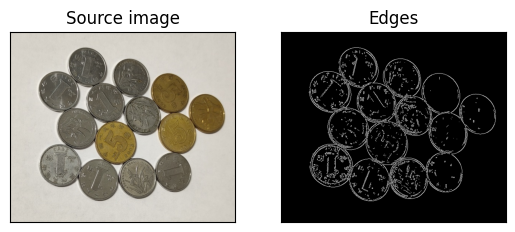

In [189]:
# Read an image from file in BGR
fn = "images/coins.jpg"
I2 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I2, np.ndarray) or I2.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Preprocess with Canny algorithm
I2edge = cv.Canny(I2, 200, 250)
# Display it
ShowImages([("Source image", I2), 
            ("Edges", I2edge)], 2)

Now we can run the Hough circles transform. Since we know that we are searching for circles in the range from $40$ to $60$ pixels, so we will define it as our radii range with step $5$.

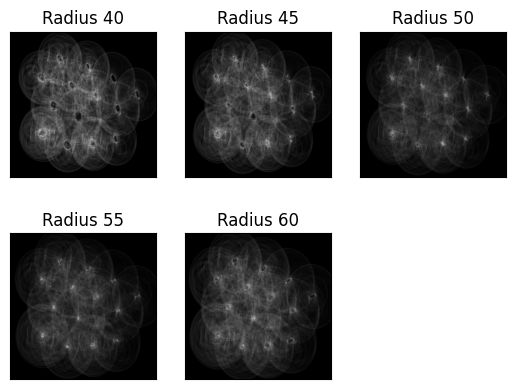

In [190]:
# Find circles with Hough transform
# Detect circles with radii in range from 40 to 60 with step 5
radii = np.arange(40, 61, 5)
I2h = skimage.transform.hough_circle(I2edge, radii)

# Show Hough parameter space
# We will resize it to make square for a better display
spaces = []
for i in range(len(radii)):
  spaces.append(("Radius {}".format(radii[i]), cv.resize(I2h[i].astype(np.float32) / np.max(I2h[i]), (I2h[i].shape[1], I2h[i].shape[1]))))
ShowImages(spaces, 3)

Now we can search for maxima values in the Hough parameter spaces and draw the found circles with subsequent calls to the `cv2.circle()` function.

Found 15 circles


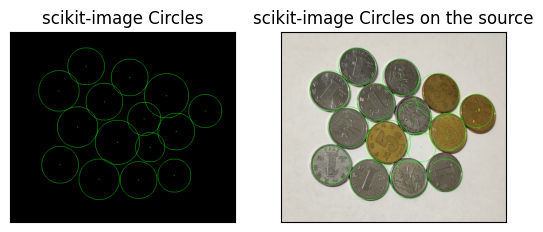

In [191]:
# Select the most prominent 10 circles
# Minimum distance between centers along X: 30
# Minimum distance between centers along Y: 30
I2accum, I2cx, I2cy, I2radii = skimage.transform.hough_circle_peaks(I2h, radii, 45, 45)#, total_num_peaks = 14)

# Create output images
I2out = I2.copy()
I2circles = np.zeros_like(I2)

# Go through all found circles and display them
if I2cx is not None and I2cy is not None and I2radii is not None:
  for i in range(0, len(I2cx)):
    center = np.int32((I2cx[i], I2cy[i]))
    radius = int(I2radii[i])
    cv.circle(I2out, center, 1, (0, 255, 0), 1)
    cv.circle(I2out, center, radius, (0, 255, 0), 1)
    cv.circle(I2circles, center, 1, (0, 255, 0), 1)
    cv.circle(I2circles, center, radius, (0, 255, 0), 1)

# Display it
print("Found {} circles".format(len(I2cx)))
ShowImages([("scikit-image Circles", I2circles), 
            ("scikit-image Circles on the source", I2out)], 2)

### **2.2.1 Self-work**

> ***Self-work***
> 
> Take **three** arbitrary images and execute the Hough transform for circles with the scikit-image library. Display the found circles and print their number.
>
> ***Notes.***
> 1. *You may have to change the Hough transform parameters to match your images.*

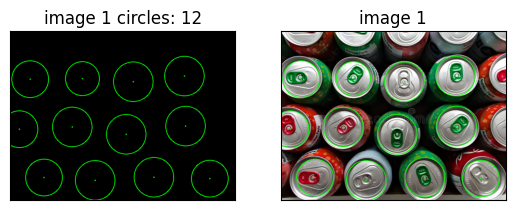

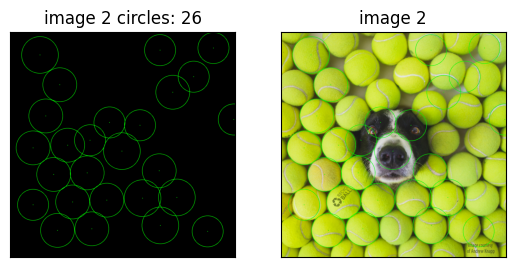

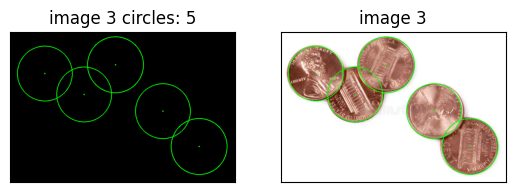

In [226]:
# TODO Place your solution here
def hough_transform_circle_sklearn(path, radii=np.arange(40, 61, 5), min_xdistance=50, min_ydistance=50):
    image = cv.imread(path, cv.IMREAD_COLOR)
    
    I2edge = cv.Canny(image, 200, 250)
    
    I2h = skimage.transform.hough_circle(I2edge, radius=radii)
    I2accum, I2cx, I2cy, I2radii = skimage.transform.hough_circle_peaks(I2h, radii, min_xdistance=min_xdistance, min_ydistance=min_ydistance)
    
    I2out = image.copy()
    I2circles = np.zeros_like(image)

    if I2cx is not None and I2cy is not None and I2radii is not None:
      for i in range(0, len(I2cx)):
        center = np.int32((I2cx[i], I2cy[i]))
        radius = int(I2radii[i])
        cv.circle(I2out, center, 1, (0, 255, 0), 2)
        cv.circle(I2out, center, radius, (0, 255, 0), 2)
        cv.circle(I2circles, center, 1, (0, 255, 0), 2)
        cv.circle(I2circles, center, radius, (0, 255, 0), 2)

    return len(I2cx), I2out, I2circles


images = ["images/task_2/1.png",
          "images/task_2/2.png",
          "images/task_2/3.png"]

# params = [{"minRadius": 60, "maxRadius": 70}, 
#           {"minDist": 150,"minRadius": 100, "maxRadius": 150, "param1": 50, "param2": 30}, 
#           {"minDist": 150, "minRadius": 80, "maxRadius": 100}]

params = [{"radii": np.arange(60, 71, 5)},
          {"radii": np.arange(110, 131, 10), "min_xdistance": 120, "min_ydistance": 120},
          {"radii": np.arange(95, 101, 2), "min_xdistance": 100, "min_ydistance": 100}]
output = []
for i, image in enumerate(images, start=1):
    n, out_img, circles_img = hough_transform_circle_sklearn(image, **params[i - 1])
    ShowImages([(f"image {i} circles: {n}", circles_img), (f"image {i}", out_img)], 2)


# **Task 3. Optional**

***Implement the classic Hough transform algorithms for lines by yourself. Compare your implementation results with the ones obtained in the first parts of the assignment. Highlight the selected points in the Hough parameter space.***

To implement the Hough transform for straight lines you have to allocate an accumulator matrix manually and implement the classic algorithm for the Hough transform to fill the accumulator matrix:

```python
For each point of the source space (x,y)
  For theta = 0 to 180
    rho = x cos theta + y sin theta
    H(theta, rho) = H(theta, rho) + 1
  end
end
```

After the accumulator matrix is filled you should select maxima. The simplest way to do it is to use the thresholding method you learned in the previous class.

***Notes.*** 
1. *Python implementation for this algorithm would be very slow so consider taking the low-resolution input image.*
2. *Don't forget to run the Canny algorithm before the Hough transform to filter the edge points.*





> ***Self-work (optional)***
> 
> Implement the Hough transform for straight lines. Display the result.

In [ ]:
# TODO Place your solution here


# **Questions**

***Please answer the following questions:***

 - *What is the main principle of the Hough transform?*
 > Переход от пространства изображения к параметрическому виду, где пересечения кривых соответствуют геометрическим фигурам (линиям или окружностям)
 >
 >

 - *May the Hough transform be used to find arbitrary contours that cannot be described analytically?*
 > Нет, только простые фигуры
 >
 >

 - *What are the recurrent and generalized Hough transforms?*
 > Рекуррентный алгоритм подходит для обработки видео потока, а обобщенный способен работать со сложными формами 
 >
 >

 - *What are the other ways of line parametrization in the Hough transform?*
 > декартовая параметризация, однородные координаты и параметризация через углы и смещения отрезков
 >
 >

# **Conclusion**

***What have you learned with this task? Don't forget to conclude it.***

 > В ходе практической работы был изучен и применён на практике алгоритм Хафа, как для выделения линий, так и окружностей. Также были рассмотрены две его реализации через библиотеку cv2 и scikit-image. 
 >
 >